In [1]:
import os
from IPython.display import Math
from IPython.display import Latex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 24, 12

import math
from pymorph.sed_trans import *
from pymorph.sed_trans_models import *
from copy import copy, deepcopy

%matplotlib inline


# Morphodynamic Modelling

Currently have implemented three different morphodynamic models based on the discussion in Wu (2007):
    <ol>
<li> 1-D Equilibrium sediment transport model,
<li> 1-D Quasi-steady non-equilibrium sediment transport model
<li> 1-D Non-equilibrium sediment transport model.
    </ol>
Note, these notes were created August 14, 2014.


## 1-D Equilibrium Sediment Transport Model

The 1-D equilibrium sediment transport model makes the assumption of local, instantaneous equilibrium for bed-load transport. In other words, the actual bed-load transport rate is equal to the transport capacity under equilibrium conditions at each computational section. In other words, $q_b = q_b^*$. Where $q_b^*$ is given by a suitable sediment transport equation:

$$ q_b^* = \frac{\sqrt{\gamma_s}D_{50}^{1.5}}{\sqrt{\rho}}8\left( Y-Y_{CR} \right)^{1.5}$$

As noted in Wu (2007), this approach ignores both the temporal and spatial lag of sediment transport. This lag is likely important to consider when modelling flows over dunes. The change in the bed is calculated using the Exner Equation:

$$(1-p'_m)\frac{\partial A}{\partial t}+\frac{\partial q_b^*}{\partial x}$$

The assumption of equilibrium sediment transport should lead to numerical problems over spatial distrubances over the bed. As shown in Wu (2007) in Figure 5.5 and 5.6, when there is a change in the sediment transport capacity, the equilibrium model on a finite discrete mesh will cause severe erosion or deposition at the downstream node (he uses the example of a mesh with a boundary condition with the sediment transport is either over or under loaded). 

## 1-D Non-Equilibrium Sediment Transport Model

Temporal and spatial lags mean that equailibrium sediment transport may not be achieved. Therefore the assumption that equilibrium conditions are present may be unrealistic and give rise to signficant errors. Therefore the non-equilibrium or unsaturated model is usually more appropriate. The general bed-load exchange model proposed by Daubert and Lebreton (1967), Wellington (1978), Nakagawa and Tsujimoto (1980), Phillips and Sutherland (1989) and Thuc (1991):

$$(1-p'_m)\frac{\partial z_b}{\partial t}=\frac{1}{L_b}\left(q_b-q_b^*\right)$$

where $L_b$ is the adaptation length of the bed load. The values $q_b/L_b$ and $q_b^*/L_b$ represent the deposition and entrainment of bed-load respectively. This formulation now requires the addition of another differential equation for the bed load $q_b$. The 1-D bed-load transport equation is give by the following (9.65):

$$\frac{\partial}{\partial t} \left(\frac{Q_b}{U_b}\right) + \frac{\partial Q_b}{\partial x} = \frac{1}{L}\left(Q_b^* - Q_b\right)$$

where $U_b$ is the bed-load velocity which can be evaluated using van Rijn (1984) or simply set to the flow velcity. $L$ is the adaptation length. When bed-load is the dominant form of transport, $L = L_b$. The value of $L_b$ varies. When bed forms are present, $L_b$ becomes related to the length of the bed-forms (e.g. $6*h$), however there are a number of differnt approximations (see discssion on page 52).  

## 1-D Quasi-Steady Non-Equilibrium Sediment Transport Model

This approach uses a step-wise quasi-steady appraoch for modelling the morphology. At each time interval, the sediment transport is assumed to be stready and the bed change is still calculated. For the quasi-steady model, the 1-D bed-load transport equation above reduces to a first-order differential equation:

$$ \frac{dQ_b}{dx} = \frac{1}{L_b}\left(Q_b^* - Q_b\right)$$

### Example: Morphological evolution of a symmetrical mound

In order to develop the model we will follow the simplified approach used by Kubatko, Westerink and Dawson (2006). First we need to generate a bed with a sine hump. Assume a simple 100m long bed and use a mesh of 201 nodes. 

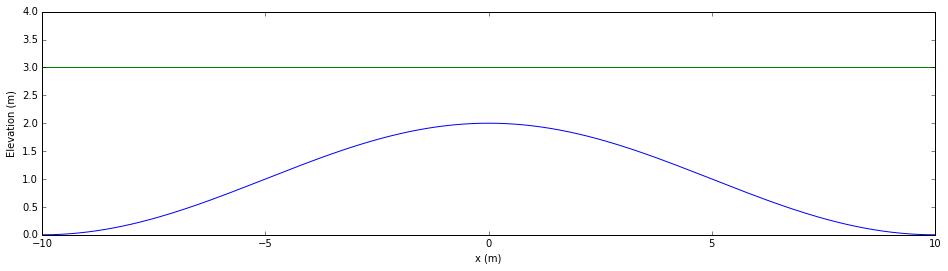

In [2]:
number_nodes =201
L = 20.0
dx = L/(number_nodes-1)

x = np.zeros(number_nodes)
zb = np.ones(number_nodes)
z = np.ones(number_nodes) 

''' Gaussian curve parameters '''
A0 = 1.0
A1 = 1.0 # mean
A2 = 5.
lam = 20.

for i in range(len(x)):
    x[i] = -lam/2. + i*dx
    zb[i] = A0 + A1*math.cos(2.0*math.pi*x[i]/lam) 
    z[i] = 3.0

h = z - zb

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,zb, label='bed')
ax1.plot(x,z, label='water surface')
plt.xlabel('x (m)')
plt.ylabel('Elevation (m)')
ax1.set_xlim([-10., 10.0])
ax1.set_ylim([0.0, 4.0])
plt.show()


We will assume that the velocity, $u$,  is a function of the flow depth, $h$ and the inflow $q_f$: 

$$u = \frac{q_f}{h} $$

We will similarly use a simplified equation for the equilibrium sedimet transport equation:

$$q_b^* = Au$$

This similificaiton is also used in the study of flow over a hump in Cowles (2013). Using the two equations we can calculate the equilibrium sediment transport and using the ODE above.

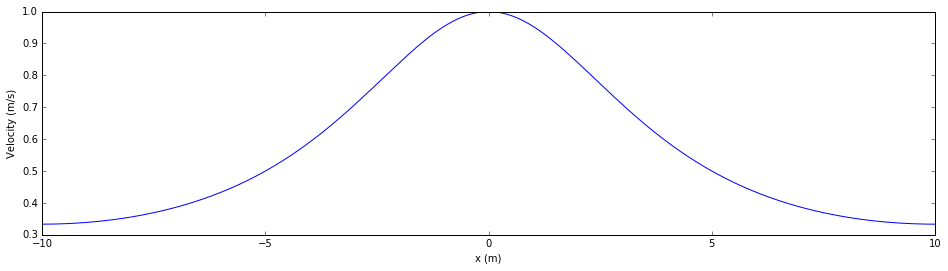

In [3]:
qf = 1.0
u = qf/h
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,u, label='velocity')
plt.xlabel('x (m)')
plt.ylabel('Velocity (m/s)')
plt.show()

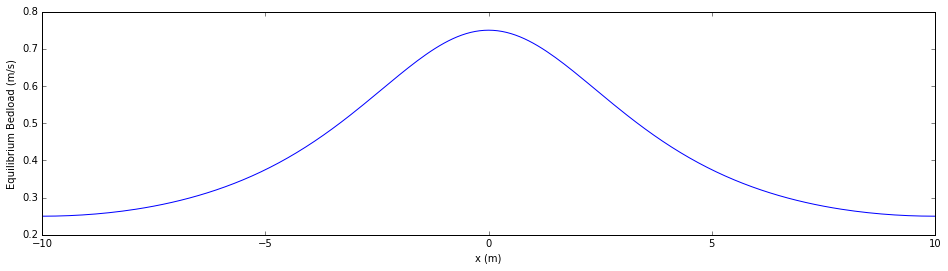

In [4]:
A = 0.75
qbstar = A * u
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,qbstar, label='bedload')
plt.xlabel('x (m)')
plt.ylabel('Equilibrium Bedload (m/s)')
plt.show()

Now if we just solve using the equilibrium assumption we get the following:

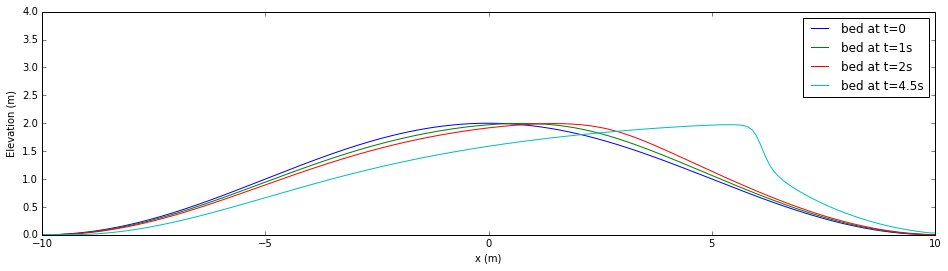

In [5]:
timesteps = 800
dt = 0.01

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,zb, label='bed at t=0')
for t in range(timesteps):
    zbn = deepcopy(zb)
    for i in range(1,number_nodes-1):
        ''' Using a simple first order upwind difference equation '''
        zb[i] = zbn[i] - (dt/(dx))*(qbstar[i]-qbstar[i-1])
        
    ''' Update the boundary conditions '''
    zb[0]=zb[1]
    zb[number_nodes-1] = zb[number_nodes-2]
    
    ''' Update the velocity and bedload '''
    h = z - zb
    u = qf/h
    qbstar = A * u
    
    if t == 100:
        ax1.plot(x,zb, label='bed at t=1s')
    elif t==200:
        ax1.plot(x,zb, label='bed at t=2s')
    elif t==200:
        ax1.plot(x,zb, label='bed at t=3s')


ax1.plot(x,zb, label='bed at t=4.5s')
plt.xlabel('x (m)')
plt.ylabel('Elevation (m)')
ax1.set_xlim([-10., 10.0])
ax1.set_ylim([0.0, 4.0])
ax1.legend()
plt.show()


Examine the erosion rate along the dune. 

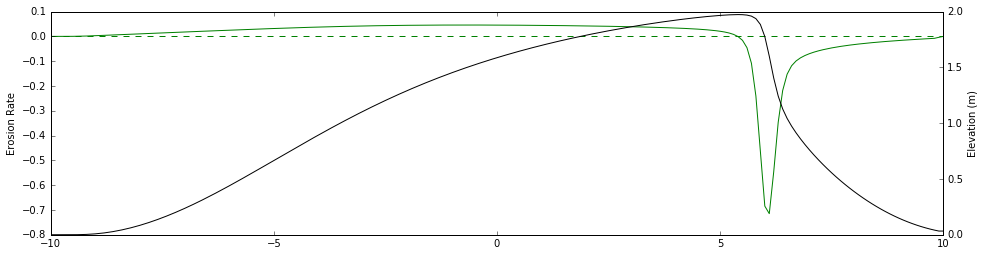

In [6]:
erosion = np.zeros(number_nodes)
y0 = np.zeros(number_nodes)
for i in range(1,number_nodes-1):
    erosion[i] = (qbstar[i+1]-qbstar[i-1])/(2.*dx)
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,erosion, label='erosion', color='g')
ax1.plot(x,y0,'g--')
ax1.set_ylabel('Erosion Rate')
ax2 = ax1.twinx()
ax2.plot(x,zb, label='bed',color='k')
ax2.set_ylabel('Elevation (m)')
plt.show()

Now we will do the same but will appy the non-equilibrium model. 

Residual after 200 iterations for exponential method: 4.36217782183e-10
Residual after 200 iterations for euler method: 2.20939905398e-17


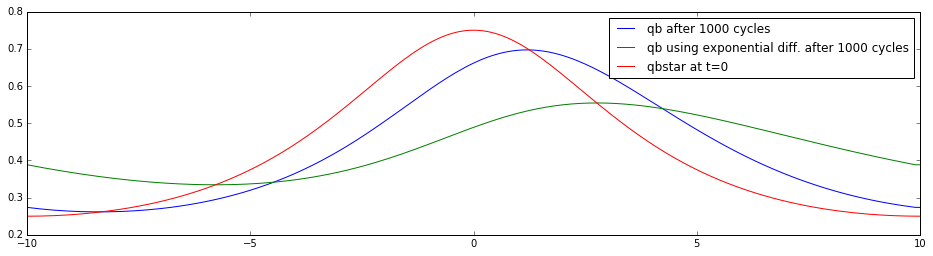

In [7]:
number_nodes =201
L = 20.0
dx = L/(number_nodes-1)

x = np.zeros(number_nodes)
zb = np.ones(number_nodes)
z = np.ones(number_nodes) 
qb = np.zeros(number_nodes) 

''' sin curve parameters '''
A0 = 1.0
A1 = 1.0 # mean
A2 = 5.
lam = 20.

''' Set up the domain '''
for i in range(len(x)):
    x[i] = -lam/2. + i*dx
    zb[i] = A0 + A1*math.cos(2.0*math.pi*x[i]/lam) 
    z[i] = 3.0
    
''' Set up the dependant variables '''
h = z - zb
qf = 1.0
u = qf/h
A = 0.75
qbstar = A * u
L = 1.5 * np.mean(h)

dt = 0.05
for iter in range(1000):
    qbnew = np.zeros(number_nodes) 
    for i in range(0,number_nodes-2):       
        #qbnew[i]= qb[i] - (dt/(dx))*(qb[i]-qb[i-1]) + (dx/L)*(qbstar[i]-qb[i])
        qbnew[i+1]= qbstar[i+1] +(qb[i] - qbstar[i])*math.exp(-dx/(2*L)) + (qbstar[i] - qbstar[i+1])*(2*L/dx)*(1-math.exp(-dx/(2*L)))
    qbnew[number_nodes-1] = qbnew[number_nodes-2]
    qbnew[0] = qbnew[number_nodes-1]
    
    resid = np.mean(qbnew-qb)
    qb = deepcopy(qbnew)

print 'Residual after 200 iterations for exponential method: %s' %resid
qb_exp = deepcopy(qb)

qb = np.zeros(number_nodes) 
for iter in range(1000):
    qbnew = np.zeros(number_nodes) 
    for i in range(1,number_nodes-1):       
        qbnew[i]= qb[i] - (dt/(dx))*(qb[i]-qb[i-1]) + (dx/L)*(qbstar[i]-qb[i])
        #qbnew[i+1]= qbstar[i+1] +(qb[i] - qbstar[i])*math.exp(-dx/(2*L)) + (qbstar[i] - qbstar[i+1])*(2*L/dx)*(1-math.exp(-dx/(2*L)))
    qbnew[number_nodes-1] = qbnew[number_nodes-2]
    qbnew[0] = qbnew[number_nodes-1]
    
    resid = np.mean(qbnew-qb)
    qb = deepcopy(qbnew)

print 'Residual after 200 iterations for euler method: %s' %resid
    
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,qb, label='qb after %s cycles' % (iter + 1))
ax1.plot(x,qb_exp, label='qb using exponential diff. after %s cycles' % (iter + 1))
ax1.plot(x,qbstar, label='qbstar at t=0')
ax1.legend()


Now run the simulation

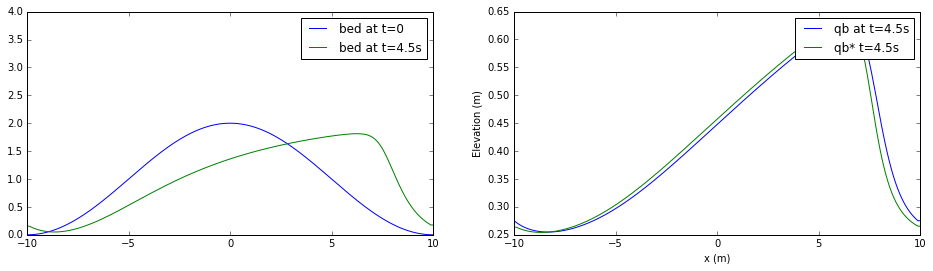

In [8]:
timesteps = 350
dt = 0.01

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(x,zb, label='bed at t=0')
for t in range(timesteps):
    zbn = deepcopy(zb)
    qbn = deepcopy(qb)
    ''' First we will solve the ODE for the sediment transport'''
    for iter in range(500):
        qbnew = np.zeros(number_nodes) 
        for i in range(1,number_nodes-1):       
            qbnew[i]= qb[i] - (dt/(dx))*(qb[i]-qb[i-1]) + (dx/L)*(qbstar[i]-qb[i])
            #qbnew[i+1]= qbstar[i+1] +(qb[i] - qbstar[i])*math.exp(-dx/(2*L)) + (qbstar[i] - qbstar[i+1])*(2*L/dx)*(1-math.exp(-dx/(2*L)))
        qbnew[number_nodes-1] = qbnew[number_nodes-2]
        qbnew[0] = qbnew[number_nodes-1]

        resid = np.mean(qbnew-qb) 
        qb = deepcopy(qbnew)
    
    
    for i in range(1,number_nodes-1):
        ''' Using a simple first order upwind difference equation '''
        zb[i] = zbn[i] - (dt/(dx))*(qbstar[i]-qb[i-1])
        
    ''' Update the boundary conditions '''
    zb[0]=zb[1]
    zb[number_nodes-1] = zb[number_nodes-2]
    
    qb[0] = qb[-1]
    qb[-1] = qb[-2]
    ''' Update the velocity and bedload '''
    h = z - zb
    u = qf/h
    qbstar = A * u


ax1.plot(x,zb, label='bed at t=4.5s')
ax2.plot(x,qb,label='qb at t=4.5s')
ax2.plot(x,qbstar,label='qb* t=4.5s')
plt.xlabel('x (m)')
plt.ylabel('Elevation (m)')
ax1.set_xlim([-10., 10.0])
ax1.set_ylim([0.0, 4.0])
ax1.legend()
ax2.legend()
plt.show()

Now plot the erosion rate which is essentially the difference between $q_b^*$ and $q_b$. When the value is greater than 0, erosion is occuring, when it is less than 0, then we have deposition. 

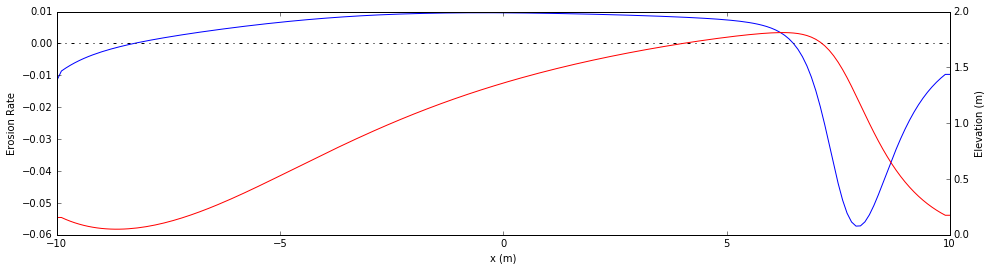

In [9]:
deltaq = (qbstar - qb)
y0 = np.zeros(number_nodes)
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,deltaq,label='Erosion Rate')
ax1.plot(x,y0,'k-.')
ax1.set_ylabel('Erosion Rate')
plt.xlabel('x (m)')
ax2 = ax1.twinx()
ax2.plot(x,zb, color='r')
ax2.set_ylabel('Elevation (m)')
plt.show()


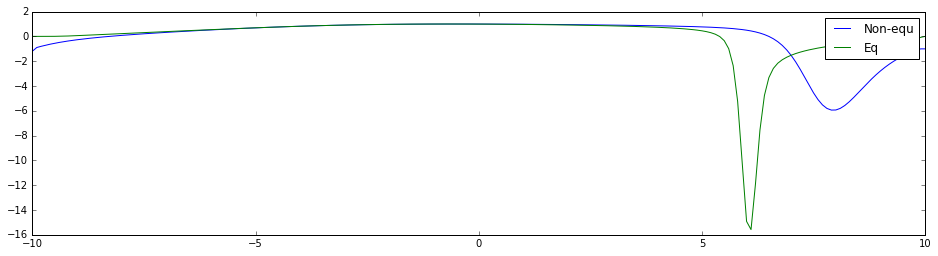

In [10]:
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax1.plot(x,deltaq/(max(deltaq)),label='Non-equ')
ax1.plot(x,erosion/(max(erosion)),label='Eq')
ax1.legend()
plt.show()